# Classifier

In [1]:
C_USE_CACHE_FILE        = "long-run-server-28-01.pkl"

In [2]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

In [4]:
# Set plot style
# TODO: Test different style
plt.style.use('ggplot')

In [5]:
dir_var                 = "./work/notebooks/"
dir_var_pandas_cache    = dir_var + "cache/pandas/"

In [6]:
# Load from cachea
dfAllDataMessages = pd.read_pickle(dir_var_pandas_cache + C_USE_CACHE_FILE)

In [7]:
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procEvalIsValidText == True]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procTDCleanText != ""]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procTDTextLength > 5]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.procChatType == "public_channel"]

dfAllDataMessages = dfAllDataMessages[dfAllDataMessages["from"].str.contains("Quer") == False]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages["from"].str.contains("QUER") == False]

dfAllDataMessages["from"].value_counts()

Oliver Janich öffentlich         30740
ATTILA HILDMANN ⚫️⚪️🔴⚔️          22885
Eva Herman Offiziell             14067
Xavier Naidoo (inoffiziell)🎵🎶     9103
Name: from, dtype: int64

In [8]:
dfAllDataMessages.columns

Index(['id', 'type', 'date', 'actor', 'actor_id', 'action', 'title', 'text',
       'from', 'from_id', 'file', 'media_type', 'mime_type',
       'duration_seconds', 'edited', 'thumbnail', 'width', 'height', 'photo',
       'forwarded_from', 'poll.question', 'poll.closed', 'poll.total_voters',
       'poll.answers', 'sticker_emoji', 'message_id', 'reply_to_message_id',
       'location_information.latitude', 'location_information.longitude',
       'live_location_period_seconds', 'via_bot', 'performer',
       'procChatFilePath', 'procChatType', 'procIsJsonFormatted',
       'tmpExtractedTD', 'procTDText', 'procTDURLs', 'procTDHashtags',
       'procTDBolds', 'procTDItalics', 'procTDUnderlines', 'procTDEmails',
       'procTDCleanText', 'procTDEmojis', 'procTDEmojisDesc', 'procTDSafeText',
       'procTDSafeLowercaseText', 'procTDTextLength', 'procEvalIsValidText',
       'procEvalContainsPhoto', 'procEvalContainsFile', 'procEvalIsEdited',
       'procEvalIsForwarded', 'procEvalContains

## Let's get started...

In [9]:
df = dfAllDataMessages[[
 'date',
 'from',
 'procEvalIsValidText',
 'procIsJsonFormatted',
 'procTDCleanText',
 'procTDSafeText',
 'procTDSafeLowercaseText',
 'procTDTextLength',
 'procEvalContainsUrl',
 'procTDURLs',
 'procEvalContainsHashtag',
 'procTDHashtags',
 'procEvalContainsBoldItem',
 'procTDBolds',
 'procEvalContainsItalicItem',
 'procTDItalics',
 'procEvalContainsUnderlineItem',
 'procTDUnderlines',
 'procEvalContainsEmailItem',
 'procTDEmails',
 'procEvalContainsEmojiItem',
 'procTDEmojis',
 'procTDEmojisDesc',
 'procEvalContainsPhoto',
 'procEvalContainsFile',
 'procEvalIsEdited',
 'procEvalIsForwarded',
 'procPipeline-ner-xlm-roberta',
 'procPipeline-ner-bert',
 'procPipeline-sen-bert',
 'procPipeline-sentiment']].copy()

In [10]:
df.head(5)

,date,from,procEvalIsValidText,procIsJsonFormatted,procTDCleanText,procTDSafeText,procTDSafeLowercaseText,procTDTextLength,procEvalContainsUrl,procTDURLs,procEvalContainsHashtag,procTDHashtags,procEvalContainsBoldItem,procTDBolds,procEvalContainsItalicItem,procTDItalics,procEvalContainsUnderlineItem,procTDUnderlines,procEvalContainsEmailItem,procTDEmails,procEvalContainsEmojiItem,procTDEmojis,procTDEmojisDesc,procEvalContainsPhoto,procEvalContainsFile,procEvalIsEdited,procEvalIsForwarded,procPipeline-ner-xlm-roberta,procPipeline-ner-bert,procPipeline-sen-bert,procPipeline-sentiment
1,2020-04-28T08:22:29,ATTILA HILDMANN ⚫️⚪️🔴⚔️,True,False,Dann schreiben wir mal Geschichte!,Dann schreiben wir mal Geschichte,dann schreiben wir mal geschichte,34,False,[],False,[],False,[],False,[],False,[],False,[],False,[],[],False,False,False,False,"{'per': [], 'misc': [], 'org': [], 'loc': []}","{'per': [], 'misc': [], 'org': [], 'loc': []}",5.0,"{'polarity': 0.0, 'subjectivity': 0.0}"
4,2020-04-28T08:43:27,ATTILA HILDMANN ⚫️⚪️🔴⚔️,True,False,Das Video sollte jeder von euch schauen und ve...,Das Video sollte jeder von euch schauen und ve...,das video sollte jeder von euch schauen und ve...,100,False,[],False,[],False,[],False,[],False,[],False,[],False,[],[],False,False,False,False,"{'per': [], 'misc': [], 'org': [], 'loc': ['▁C...","{'per': [], 'misc': [], 'org': [], 'loc': []}",5.0,"{'polarity': 0.0, 'subjectivity': 0.0}"
5,2020-04-28T08:43:31,ATTILA HILDMANN ⚫️⚪️🔴⚔️,True,True,SCHAUT ES EUCH AN!,SCHAUT ES EUCH AN,schaut es euch an,21,True,[https://www.instagram.com/tv/B_f_sYFqfvw/?igs...,False,[],False,[],False,[],False,[],False,[],True,[🆘],[SOS button],False,False,True,False,"{'per': [], 'misc': [], 'org': [], 'loc': []}","{'per': [], 'misc': [], 'org': [], 'loc': []}",5.0,"{'polarity': 0.0, 'subjectivity': 0.0}"
6,2020-04-28T08:45:01,ATTILA HILDMANN ⚫️⚪️🔴⚔️,True,False,"Billyboy spricht schon heute, APRIL 2020, von ...",Billyboy spricht schon heute APRIL 2020 von ...,billyboy spricht schon heute april 2020 von ...,129,False,[],False,[],False,[],False,[],False,[],False,[],False,[],[],False,False,False,False,"{'per': ['▁Billy', 'boy'], 'misc': ['▁PAN'], '...","{'per': ['bill', '##y', '##boy'], 'misc': [], ...",1.0,"{'polarity': 0.0, 'subjectivity': 0.0}"
7,2020-04-28T08:45:48,ATTILA HILDMANN ⚫️⚪️🔴⚔️,True,False,Beachtet sein Grinsen am Anfang und Ende des V...,Beachtet sein Grinsen am Anfang und Ende des V...,beachtet sein grinsen am anfang und ende des v...,191,False,[],False,[],False,[],False,[],False,[],False,[],False,[],[],False,False,False,False,"{'per': [], 'misc': [], 'org': [], 'loc': []}","{'per': [], 'misc': [], 'org': [], 'loc': []}",2.0,"{'polarity': 0.125, 'subjectivity': 0.0}"


In [11]:
df['class-from']    = df['from']
df['class-from-id'] = df['from'].factorize()[0]
df['class-text']    = df['procTDCleanText']

In [12]:
df["class-from"].value_counts()

Oliver Janich öffentlich         30740
ATTILA HILDMANN ⚫️⚪️🔴⚔️          22885
Eva Herman Offiziell             14067
Xavier Naidoo (inoffiziell)🎵🎶     9103
Name: class-from, dtype: int64

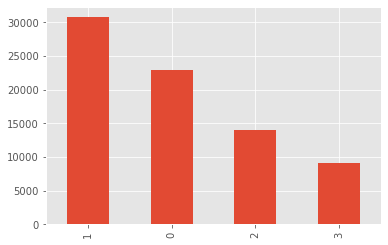

In [13]:
_ = df["class-from-id"].value_counts().plot.bar()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df['class-text'], df['class-from'], random_state = 42, test_size=0.30)

In [16]:
x_train

10827    YouTube hat mein letztes Video geloescht. Das ...
39829    "World Economic Forum will Kapitalismus und So...
36070    FAUCI, TRUMP UND SEINE KOMPLETTE ADMINISTRATIO...
35412                        Folg dem Wolf @ATTILAHILDMANN
9937     Falls euch eure Privatsphaere wichtig ist, dan...
                               ...                        
24125                                        Auf Twitter: 
11036                  WILDE TIGER BIO FRUCHTGUMMIS       
6807     Wuhan-Shake: Corona-Gruss wird zum viralen Hit...
1682     Die Links wurden mir dazugeschickt! Ich bekam ...
26734                                  Die und der Klausi 
Name: class-text, Length: 53756, dtype: object

In [17]:
y_train

10827         Oliver Janich öffentlich
39829         Oliver Janich öffentlich
36070          ATTILA HILDMANN ⚫️⚪️🔴⚔️
35412          ATTILA HILDMANN ⚫️⚪️🔴⚔️
9937     Xavier Naidoo (inoffiziell)🎵🎶
                     ...              
24125         Oliver Janich öffentlich
11036          ATTILA HILDMANN ⚫️⚪️🔴⚔️
6807              Eva Herman Offiziell
1682           ATTILA HILDMANN ⚫️⚪️🔴⚔️
26734          ATTILA HILDMANN ⚫️⚪️🔴⚔️
Name: class-from, Length: 53756, dtype: object

In [40]:
print("Train size:\t" + str(len(x_train.index)))
print("Test size:\t" + str(len(x_test.index)))

Train size:	53756
Test size:	23039


In [74]:
aTarget = CountVectorizer().fit_transform(x_train)

tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(aTarget)

tfidf_transformer2 = TfidfTransformer()
x_test_tfidf = tfidf_transformer2.fit_transform(CountVectorizer(aTarget.vocabulary_).fit_transform(x_test))

NotFittedError: Vocabulary not fitted or provided

In [62]:
clf = MultinomialNB().fit(x_train_tfidf, y_train)

In [47]:
clf

MultinomialNB()

In [66]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [67]:
predictTrain    = clf.predict(x_train_tfidf)

In [70]:
predictTest     = clf.predict(x_test_tfidf)

ValueError: dimension mismatch

In [51]:
accuracy_score(predictTrain, y_train)

0.7406615075526453

In [52]:
accuracy_score(predictTest, y_test)

NameError: name 'predictTest' is not defined

In [ ]:
print(str(confusion_matrix(predictTrain, y_train)))

In [ ]:
print(str(confusion_matrix(predictTest, y_test)))